In [1]:
!pip install seaborn


In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [5]:
csv_path = r'C:\Users\karth\Desktop\jupyter projects\LongHairGenderDetection\data\list_attr_celeba.csv'
df = pd.read_csv(csv_path)

if 'filename' not in df.columns:
    df.insert(0, 'filename', [f"{i:06d}.jpg" for i in range(1, len(df) + 1)])

df.replace(-1, 0, inplace=True)

df['age'] = 25

required_cols = ['Bald', 'Bangs', 'Male']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in CSV.")


In [6]:
def infer_hair_length(row):
    if row['Bald'] == 1:
        return 'short'
    elif row['Bangs'] == 1:
        return 'long'
    elif row['Male'] == 1:
        return 'short'
    else:
        return 'long'

df['hair_length'] = df.apply(infer_hair_length, axis=1)
df[['filename', 'hair_length']].head()


,filename,hair_length
0,000001.jpg,long
1,000002.jpg,long
2,000003.jpg,short
3,000004.jpg,long
4,000005.jpg,long


In [7]:
image_dir = r'C:\Users\karth\Desktop\jupyter projects\LongHairGenderDetection\data\img_align_celeba'
X_data = []
y_labels = []

sample_df = df.sample(n=10000, random_state=42)

for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    img_path = os.path.join(image_dir, row['filename'])
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))
        X_data.append(img)
        y_labels.append(0 if row['hair_length'] == 'short' else 1)

X_data = np.array(X_data, dtype='float32') / 255.0
y_labels = to_categorical(y_labels)


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.61it/s]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

In [9]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\karth\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,410 (6.20 MB)

 Trainable params: 1,625,410 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64
)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.9945 - loss: 0.0123 - val_accuracy: 0.9335 - val_loss: 0.4150
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.9963 - loss: 0.0111 - val_accuracy: 0.9365 - val_loss: 0.4198
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.9947 - loss: 0.0134 - val_accuracy: 0.9340 - val_loss: 0.4213
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.9938 - loss: 0.0157 - val_accuracy: 0.9370 - val_loss: 0.3851
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.9960 - loss: 0.0099 - val_accuracy: 0.9300 - val_loss: 0.4629
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9970 - loss: 0.0068 - val_accuracy: 0.9280 - val_loss: 0.5074
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.9970 - loss: 0.0069 - val_accuracy: 0.9380 - val_loss: 0.5118
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9966 - loss: 0.0113

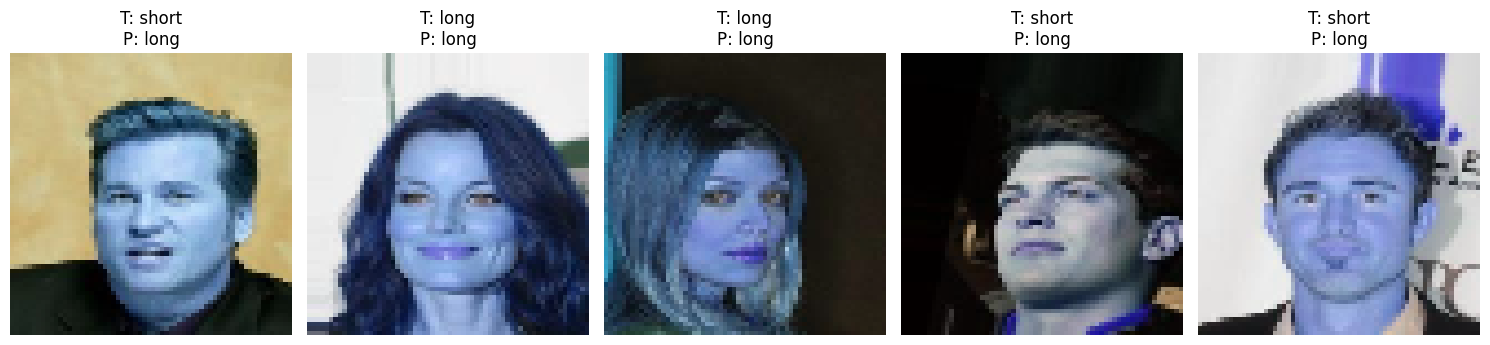

In [10]:
import random
import matplotlib.pyplot as plt

class_names = ['short', 'long']

num_samples = 5
indices = random.sample(range(len(X_test)), num_samples)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))

for i, idx in enumerate(indices):
    img = X_test[idx]
    true_label = class_names[np.argmax(y_test[idx])]
    pred_label = class_names[np.argmax(model.predict(img[np.newaxis, ...], verbose=0))]

    axes[i].imshow(img)
    axes[i].set_title(f"T: {true_label}\nP: {pred_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

cr = classification_report(y_true, y_pred, target_names=['Short Hair', 'Long Hair'])
print("\nClassification Report:\n", cr)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Confusion Matrix:
 [[   1  761]
 [   3 1235]]

Classification Report:
               precision    recall  f1-score   support

  Short Hair       0.25      0.00      0.00       762
   Long Hair       0.62      1.00      0.76      1238

    accuracy                           0.62      2000
   macro avg       0.43      0.50      0.38      2000
weighted avg       0.48      0.62      0.47      2000



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


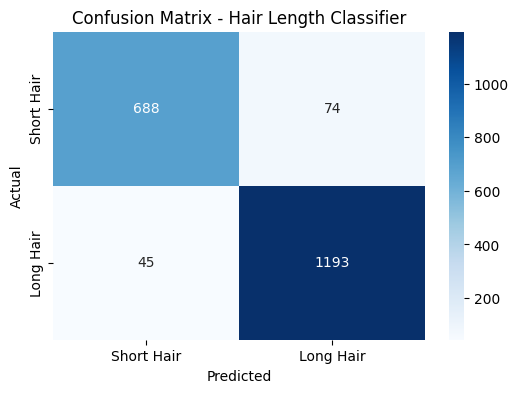

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Short Hair', 'Long Hair'], yticklabels=['Short Hair', 'Long Hair'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Hair Length Classifier')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


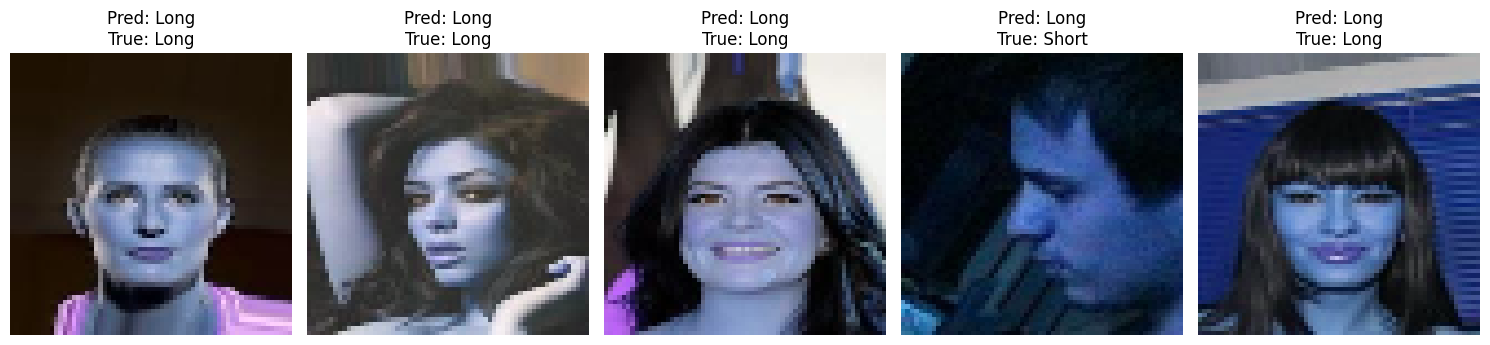

In [12]:
import random
import matplotlib.pyplot as plt

label_map = {0: 'Short', 1: 'Long'}

random_indices = random.sample(range(len(X_test)), 5)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    img = X_test[idx]
    true_label = np.argmax(y_test[idx])
    pred_label = np.argmax(model.predict(img.reshape(1, 64, 64, 3)))

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {label_map[pred_label]}\nTrue: {label_map[true_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
model.save("hair_length_classifier_model.h5")

In [14]:
from tensorflow.keras.models import load_model

model = load_model("hair_length_classifier_model.h5")


In [15]:
test_image_dir = r"C:\Users\karth\Desktop\jupyter projects\LongHairGenderDetection\test_images"
os.makedirs(test_image_dir, exist_ok=True)

for i, img in enumerate(X_test):
    filename = os.path.join(test_image_dir, f"test_{i}.jpg")
    cv2.imwrite(filename, (img * 255).astype('uint8'))

print("Test images saved to:", test_image_dir)

Test images saved to: C:\Users\karth\Desktop\jupyter projects\LongHairGenderDetection\test_images
